In [1]:
# import libraries
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
print('tensorflow version: ', tf.__version__)

tensorflow version:  2.18.0


In [2]:
# define file path
file_path = os.path.join('..', 'data', 'main.csv')

# read csv file
if not os.path.isfile(file_path):
     print(f'File not found at {file_path}.')
else:
     data = pd.read_csv(file_path, parse_dates=['date'])
     print(f'Data loaded with shape: {data.shape}.')

Data loaded with shape: (559, 10).


In [3]:
# preview of data
data.head(1)

,date,patient_id,left_freq_500_hz,left_freq_1000_hz,left_freq_2000_hz,left_freq_4000_hz,right_freq_500_hz,right_freq_1000_hz,right_freq_2000_hz,right_freq_4000_hz
0,2022-01-15,50,5.0,10.0,5.0,10.0,10.0,0.0,0.0,10.0


In [4]:
def normalization(df):
    """Normalize data from dataframe."""

    feature_scaled = df.copy()
    scaler = MinMaxScaler()
    features = feature_scaled.columns[2:]

    for feature in features:
        feature_scaled[feature] = scaler.fit_transform(df[[feature]])

    return feature_scaled

In [5]:
feature_scaled = normalization(data)
feature_scaled.tail(2)

,date,patient_id,left_freq_500_hz,left_freq_1000_hz,left_freq_2000_hz,left_freq_4000_hz,right_freq_500_hz,right_freq_1000_hz,right_freq_2000_hz,right_freq_4000_hz
557,2023-07-26,50,0.997,0.995,0.998,0.9988,0.994,0.996667,0.994,0.998333
558,2023-07-27,50,1.000,1.000,1.000,1.0000,1.000,1.000000,1.000,1.000000


**Insight**:

The latest test results are often the highest because the gradual decline occurs slowly in this case.

In [6]:
def feature_extraction(df: pd.DataFrame):
  """Extract feature from dataframe."""

  features = df.iloc[:, 2:].values
  time = np.arange(len(features))

  return features, time

In [7]:
features, time = feature_extraction(feature_scaled)

In [8]:
print(f'Features shape: {features.shape}')
print(f'Length of each series: {len(features)}')
print(f'Length of time: {len(time)}')

Features shape: (559, 8)
Length of each series: 559
Length of time: 559


In [9]:
# preview of features and time
features[4:5], time[:10]

(array([[0.        , 0.        , 0.        , 0.0132    , 0.        ,
         0.00733333, 0.        , 0.011     ]]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

In [10]:
def plot_series(time, series, format="-", start=0, end=None):
    """Plot multiple features."""

    plt.figure(figsize=(15, 8))

    for i in range(8):
        plt.subplot(2, 4, i + 1)
        plt.plot(time[start:end], series[:, i][start:end], format)
        plt.title(f"Feature {i+1}")
        plt.xlabel("Time")
        plt.ylabel("Hearing Levels (dB)")
        plt.grid(True)

    plt.tight_layout()
    plt.show()

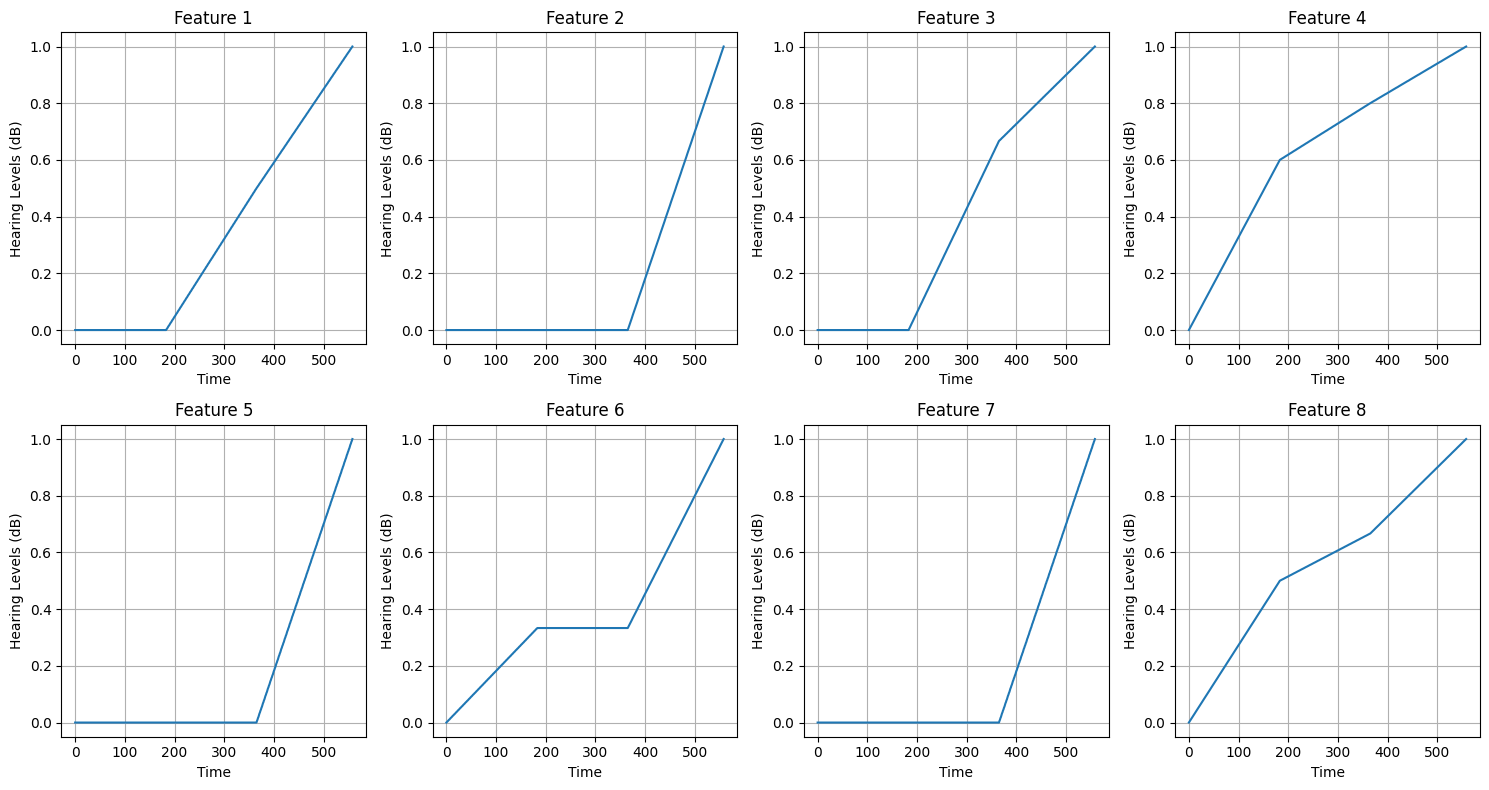

In [11]:
# plot multiple features
plot_series(time, features)

In [12]:
# global variables
SPLIT_TIME = int(0.8*len(features))
WINDOW_SIZE = 30
BATCH_SIZE = 4

In [13]:
def train_val_split(time, series):
    """Splits time series into train and validations sets."""

    time_train = time[:SPLIT_TIME]
    series_train = series[:SPLIT_TIME]
    time_valid = time[SPLIT_TIME:]
    series_valid = series[SPLIT_TIME:]

    return time_train, series_train, time_valid, series_valid

In [14]:
# split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(time, features)

In [15]:
def plot_train_test(time_train, series_train, time_valid, series_valid):
    """Plot train and test data."""

    plt.figure(figsize=(15, 8))

    for i in range(8):
        plt.subplot(2, 4, i + 1)
        plt.plot(time_train, series_train[:, i], label='Train data')
        plt.plot(time_valid, series_valid[:, i], label='Test data')
        plt.title(f"Feature {i+1}")
        plt.xlabel("Time")
        plt.ylabel("Hearing Levels (dB)")
        plt.grid(True)

        if i == 0:
            plt.legend()

    plt.tight_layout()
    plt.show()

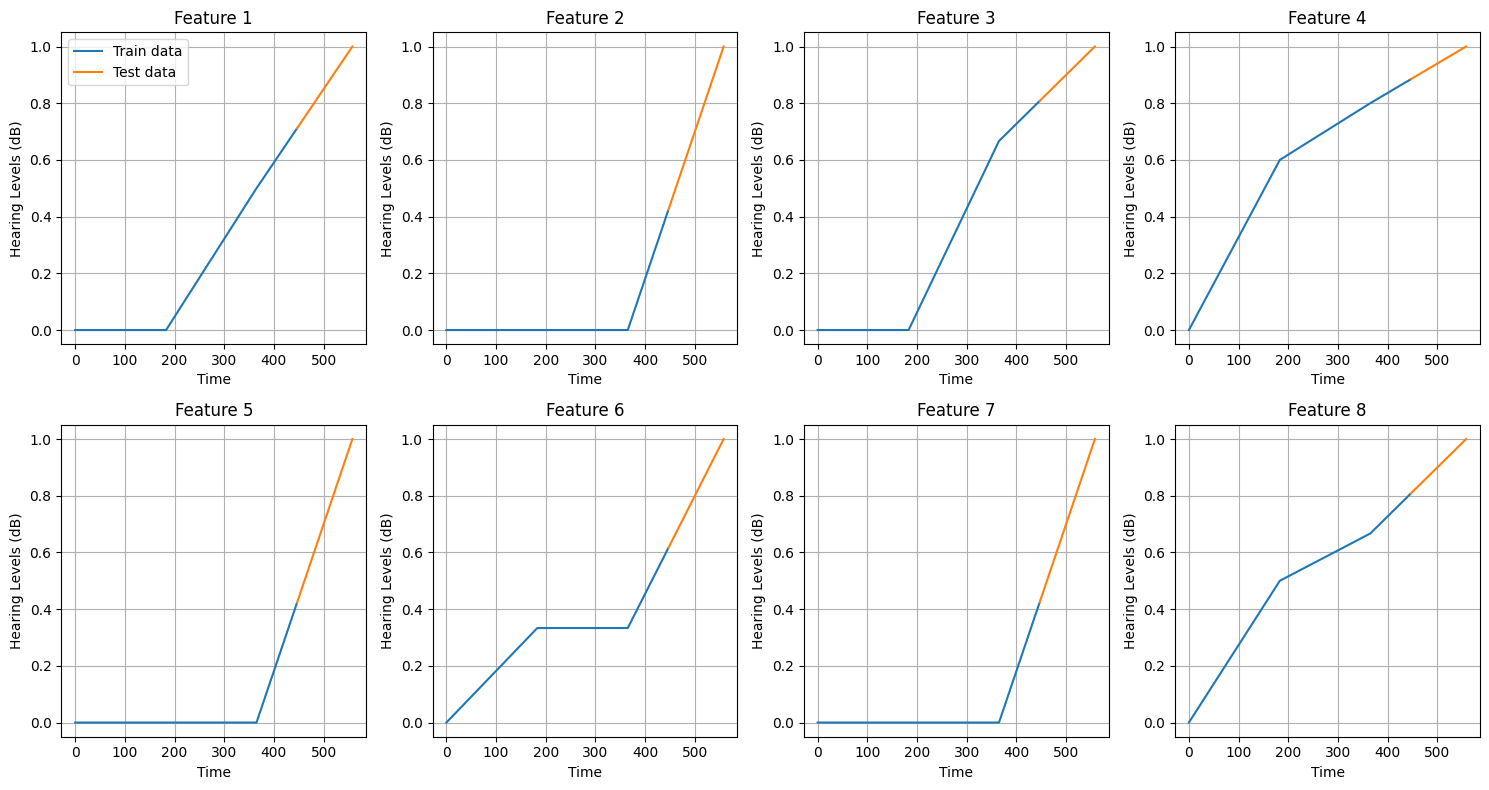

In [16]:
# plot train and validation data
plot_train_test(time_train, series_train, time_valid, series_valid)

In [17]:
def windowed_dataset(series, window_size):
  """Creates windowed dataset."""

  dataset = (tf.data.Dataset.from_tensor_slices(series)
              .window(window_size + 1, shift=1, drop_remainder=True)
              .flat_map(lambda window: window.batch(window_size + 1))
              .map(lambda window: (window[:-1], window[-1]))
              .batch(BATCH_SIZE)
              .prefetch(1))
  return dataset

In [18]:
# apply the transformation to the training set
train_dataset = windowed_dataset(series_train, window_size=WINDOW_SIZE)

In [19]:
for windows in train_dataset.take(1):
  print(f'Data type: {type(windows)}')
  print(f'Number of elements in the tuple: {len(windows)}')
  print(f'Shape of first element: {windows[0].shape}')
  print(f'Shape of second element: {windows[1].shape}')

Data type: <class 'tuple'>
Number of elements in the tuple: 2
Shape of first element: (4, 30, 8)
Shape of second element: (4, 8)


### Tune learning rate

In [20]:
def create_uncompiled_model():
    """Create model for predictions with 8 features."""

    model = tf.keras.models.Sequential([
        tf.keras.Input(shape=(WINDOW_SIZE, 8), name="input_layer"),
        tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                               strides=1, padding="causal",
                               activation="relu", name="conv1"),
        tf.keras.layers.Conv1D(filters=32, kernel_size=3,
                               strides=1, padding="causal",
                               activation="relu", name="conv2"),
        tf.keras.layers.GlobalAveragePooling1D(name="global_avg_pool"),
        tf.keras.layers.Dense(64, activation="relu", name="dense1"),
        tf.keras.layers.Dense(8, name="output_layer")
    ])

    return model


In [21]:
# make uncompiled model
uncompiled_model = create_uncompiled_model()

In [22]:
# summary of model architecture
uncompiled_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv1D)                  │ (None, 30, 64)         │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv1D)                  │ (None, 30, 32)         │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,408 (40.66 KB)

 Trainable params: 10,408 (40.66 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
def adjust_learning_rate(model):
    """Fit model using different learning rates."""

    lr_schedule = tf.keras.callbacks.LearningRateScheduler(
        lambda epoch: 1e-4 * 10**(epoch / 20))

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

    model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae', 'mse'])

    history = model.fit(train_dataset,
                        epochs=100,
                        batch_size=32,
                        callbacks=[lr_schedule])

    return history

In [24]:
lr_history = adjust_learning_rate(uncompiled_model)

Epoch 1/100


105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0112 - mae: 0.0996 - mse: 0.0224 - learning_rate: 1.0000e-04
Epoch 2/100
 31/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0022 - mae: 0.0464 - mse: 0.0043 

C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0038 - mae: 0.0666 - mse: 0.0075 - learning_rate: 1.1220e-04
Epoch 3/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0025 - mae: 0.0572 - mse: 0.0049 - learning_rate: 1.2589e-04
Epoch 4/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0020 - mae: 0.0503 - mse: 0.0039 - learning_rate: 1.4125e-04
Epoch 5/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.5690e-04 - mae: 0.0343 - mse: 0.0019 - learning_rate: 1.5849e-04
Epoch 6/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.3565e-04 - mae: 0.0274 - mse: 0.0013 - learning_rate: 1.7783e-04
Epoch 7/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.1388e-04 - mae: 0.0280 - mse: 0.0012 - learning_rate: 1.9953e-04
Epoch 8/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.1243e-04 - mae: 0.0286 - mse: 0.0012 - learning_rate: 2.2387e-04
Epoch 9/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.0994e-04 - mae: 0.0265 - mse: 0.0010 - learning_rate: 2.5119e-04


(np.float64(0.0001), np.float64(1.0), np.float64(0.0), np.float64(0.1))

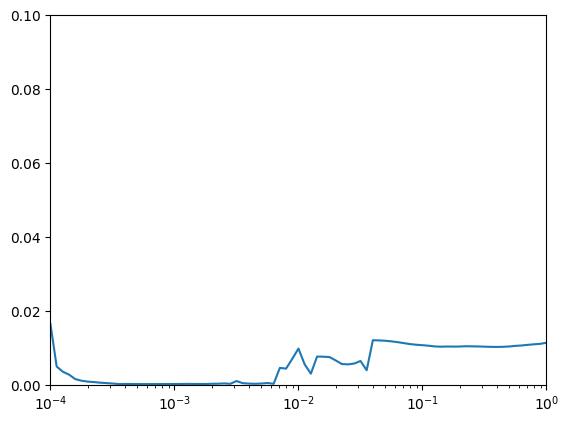

In [25]:
# plot learning rate loss
plt.semilogx(lr_history.history["learning_rate"], lr_history.history["loss"])
plt.axis([1e-4, 1, 0, 0.1])

### compiling model

In [26]:
def create_model():
    """Create model for predictions."""

    model = create_uncompiled_model()

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  metrics=['mae'])


    return model

In [27]:
# create model
model = create_model()

In [28]:
print(f'Model input shape: {model.input_shape}')
print(f'Model output shape: {model.output_shape}')

Model input shape: (None, 30, 8)
Model output shape: (None, 8)


In [ ]:
example_batch = train_dataset.take(1)

try:
    uncompiled_model.evaluate(example_batch, verbose=False)
except Exception as e:
    print("Model is not compatible with the dataset defined earlier. Check that the loss function and last layer are compatible with one another.")
    print("Error message:", e)
else:
    predictions = uncompiled_model.predict(example_batch, verbose=False)
    print(f"predictions have shape: {predictions.shape}")

predictions have shape: (4, 8)


In [30]:
# train the model
early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='loss', patience=20, restore_best_weights=True)

history = model.fit(train_dataset, epochs=100, batch_size=32, callbacks=[early_stopping])

Epoch 1/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 9.6840e-04 - mae: 0.0261
Epoch 2/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0019 - mae: 0.0441
Epoch 3/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.0631e-04 - mae: 0.0262
Epoch 4/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.9887e-04 - mae: 0.0214
Epoch 5/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.3807e-04 - mae: 0.0225
Epoch 6/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.3006e-04 - mae: 0.0218
Epoch 7/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.0243e-04 - mae: 0.0258
Epoch 8/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.7055e-04 - mae: 0.0172
Epoch 9/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.6210e-04 - mae: 0.0203
Epoch 10/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.0309e-04 - mae: 0.0195
Epoch 11/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.2065e-04 - mae: 0.0228
Epoch 12/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - 

In [31]:
def compute_metrics(true_series, forecast):
    """Compute MSE and MAE for 8 features."""

    mse_per_feature = tf.keras.losses.MSE(true_series, forecast)
    mae_per_feature = tf.keras.losses.MAE(true_series, forecast)

    mse_avg = tf.reduce_mean(mse_per_feature)
    mae_avg = tf.reduce_mean(mae_per_feature)

    return mse_per_feature, mae_per_feature, mse_avg, mae_avg

In [32]:
def generate_forecast(model, series, window_size):
    """Generates a forecast using trained model."""

    ds = (tf.data.Dataset.from_tensor_slices(series)
          .window(window_size, shift=1, drop_remainder=True)
          .flat_map(lambda w: w.batch(window_size))
          .batch(32)
          .prefetch(1))
    forecast = model.predict(ds)
    return forecast

In [33]:
# make cnn forecast
cnn_forecast = generate_forecast(model, features[SPLIT_TIME - WINDOW_SIZE:-1], WINDOW_SIZE)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


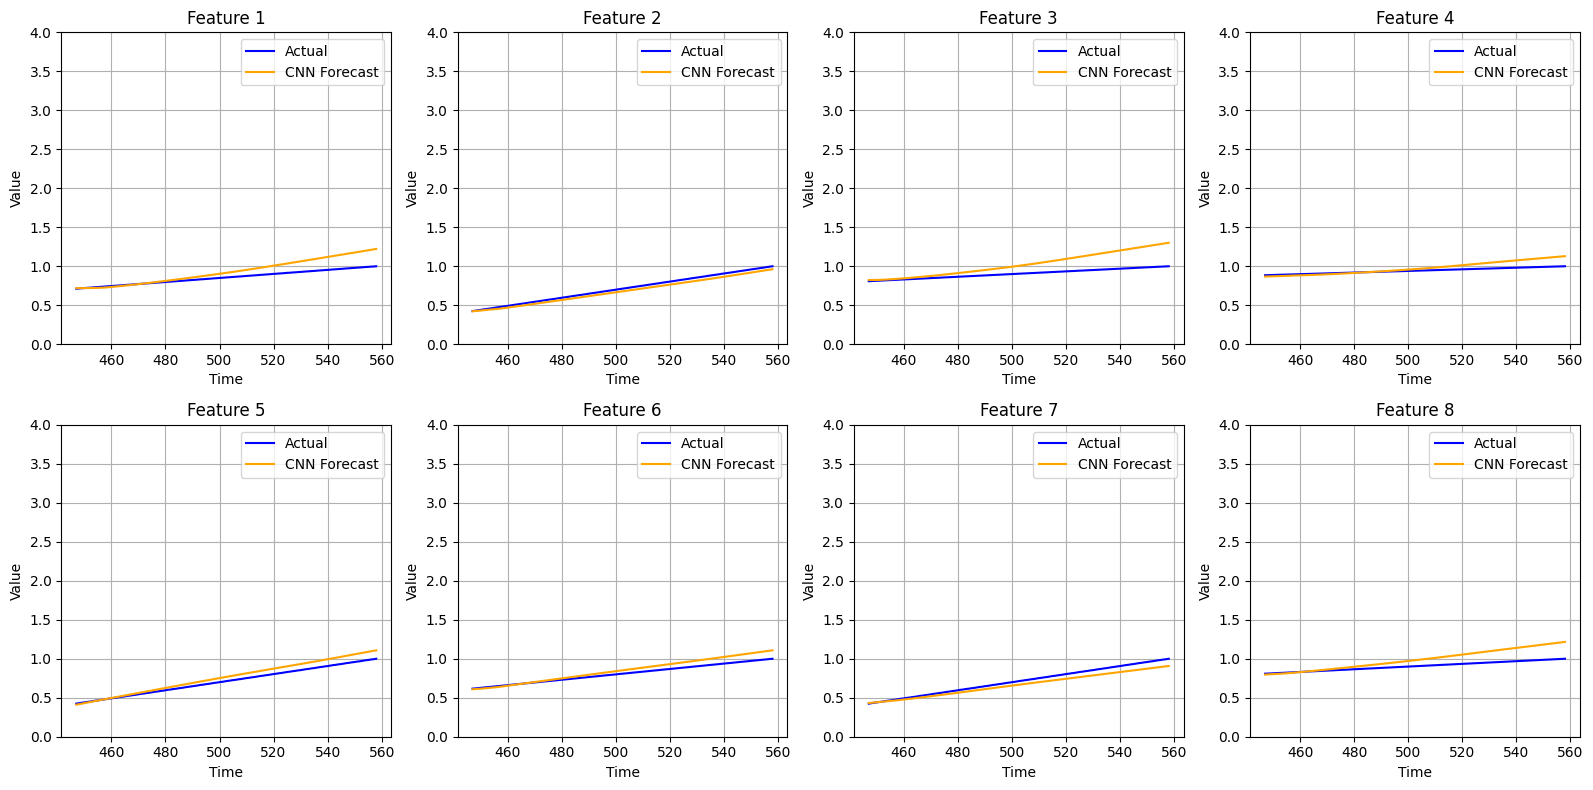

In [34]:
# plot forecast
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for i in range(8):
    ax = axes[i // 4, i % 4]
    ax.plot(time_valid, series_valid[:, i], label='Actual', color='blue')
    ax.plot(time_valid, cnn_forecast[:, i], label='CNN Forecast', color='orange')
    ax.set_title(f"Feature {i+1}")
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    ax.set_ylim(0, 4)
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

In [35]:
# calculate avg of MSE and MAE
mse_per_feature, mae_per_feature, mse_avg, mae_avg = compute_metrics(series_valid, cnn_forecast)
#print("MSE per feature:", mse_per_feature.numpy())
#print("MAE per feature:", mae_per_feature.numpy())
print("Average MSE:", mse_avg.numpy())
print("Average MAE:", mae_avg.numpy())

Average MSE: 0.007554185
Average MAE: 0.063431524


In [ ]:
# save the model in the .keras format
model.save('model_conv1d.keras')

# load the model in .keras format
model_conv1d = tf.keras.models.load_model('model_conv1d.keras')